In [27]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
from classy import Class
from copy import deepcopy
import torch
import sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
import sys
from scipy import stats
from sbi.utils.get_nn_models import posterior_nn
import pickle
from tqdm import tqdm


#path_to_file = 'path/to/cosmoped'
path_to_file = '/Users/aisulu/Desktop/moped_sbi/cosmoped'
if path_to_file not in sys.path:
    sys.path.append(path_to_file)

path_to_bank = '/Users/aisulu/Desktop/gcloud_files'
if path_to_bank not in sys.path:
    sys.path.append(path_to_bank)

from cosmoped_likelihood import CosMOPED

DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

file_path = '/Users/aisulu/Desktop/report_code/noise_fake_planck_realistic_two.dat'

try:
    fpr = np.loadtxt(file_path)
except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

lmax=2500
fsky=1.0
ell=np.array([l for l in range(2,lmax+1)])
ells=ell*(ell+1)/(2*np.pi)

Nltt = fpr[ell-2,1]

In [2]:
path='/Users/aisulu/Desktop/report_code/LambdaCDM/'
TT2018=CosMOPED(path, year=2018, spectra='TT', use_low_ell_bins=False)

with open ('/Users/aisulu/Desktop/report_code/samples/samples_10000_sim_wishart.pkl', 'rb') as file:
    samples_store = pickle.load(file)

In [3]:
pl=[0.676, 0.0224, 0.12, 3.0753, 0.965]
sigss = [0.007280314019205051, 0.00016000424178571937, 0.001652310824066368, 0.003472400357728407, 0.004155629403002546]

def find_bounds(k):
    hw = 25 * sigss[k]
    min = pl[k] - hw
    max = pl[k] + hw
    return min, max
param_min = []
param_max = []
for i in range(5):
    min, max = find_bounds(i)
    param_min.append(min)
    param_max.append(max)

In [4]:
def simulator(v):
    V=np.around(v, decimals=6)
    H, omega_b, omega_cdm, lnAs,n_s=V[0],V[1],V[2],V[3],V[4]
    h = H/100
    A_s=np.exp(lnAs)/ 1.e10
    params = {
        'output': 'tCl pCl lCl',
        'l_max_scalars': lmax,
        'lensing': 'yes',
        'h': h,
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'A_s': A_s,
        'n_s': n_s,
    }
    cosmo = Class()
    cosmo.set(params)
    try:
        cosmo.compute(['lensing'])
        cls = cosmo.lensed_cl(lmax)
        T=cosmo.T_cmb()
        cosmo.struct_cleanup()
        cosmo.empty()
        return dict(TT=cls['tt'][ell]*(T*1.e6)**2+Nltt)
    except Exception as e:
        print("a simulation failed!")
        print(f"An error occurred: {e}")
        return dict(TT=np.nan)

In [45]:
cls = samples_store['x']
params = samples_store['z']
print(params[0])

prior = utils.BoxUniform(low=torch.as_tensor(param_min),
                         high=torch.as_tensor(param_max))

inference = SNPE(prior=prior)

inference = inference.append_simulations(torch.tensor(params[:5000], dtype = torch.float32), 
                                         torch.tensor(cls[:5000], dtype = torch.float32))

compression_vector_dict, compressed_data_dict = TT2018.read_compression_vectors_and_compressed_data(path)
compress_vec_h = compression_vector_dict['h'][:2499]
compress_vec_ombh2 = compression_vector_dict['omega_b'][:2499]
compress_vec_omch2 = compression_vector_dict['omega_cdm'][:2499]
compress_vec_As = compression_vector_dict['A_s'][:2499]
compress_vec_ns = compression_vector_dict['n_s'][:2499]

def simulator_wrapper(params):
    dict_cl = simulator(np.array(params))['TT']
    output = [compress_vec_h.dot(dict_cl), compress_vec_ombh2.dot(dict_cl), compress_vec_omch2.dot(dict_cl), compress_vec_As.dot(dict_cl),compress_vec_ns.dot(dict_cl)]
    return torch.tensor(output)

observed_dataset = simulator_wrapper(pl)
print(observed_dataset)

[0.711917   0.023041   0.11872233 3.0918396  0.97982085]
tensor([ -40.2245, -532.5961, -331.3584,  227.0576, -413.4179],
       dtype=torch.float64)


In [46]:
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)
proposal = posterior.set_default_x(observed_dataset)

 Neural network successfully converged after 103 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

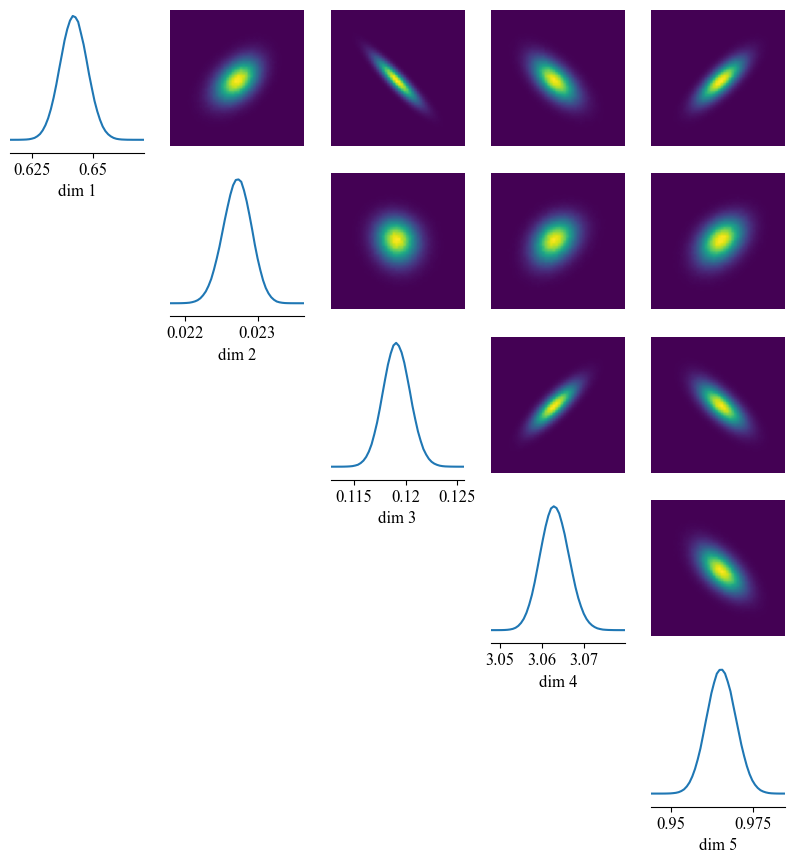

In [22]:
proposal = posterior.set_default_x(cls[5])
posterior_samples = posterior.sample((1000000,))
from sbi.analysis import pairplot
fig, ax = pairplot(
    samples=posterior_samples,
    offdiag=["kde"],
    diag=["kde"],
    figsize=(10, 10),
)

In [28]:
data = np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-24_10000__1.txt')
data = np.concatenate((data,np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-25_10000__1.txt')),axis=0)
data = np.concatenate((data,np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-25_20000__3.txt')),axis=0)
data = np.concatenate((data,np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-25_20000__4.txt')),axis=0)
data = np.concatenate((data,np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-25_30000__1.txt')),axis=0)

data_reshape = []
for i in range(len(data)):
    sample = [data[i][2]-0.032-3e-3-0.0105+0.00920, (data[i][3]-0.075)/1, data[i][4]+0.011-5.775e-3+4e-3-8.25e-4, 
              np.log(10*data[i][5])-0.113-0.0175+0.0116-0.000526, data[i][6]+2e-3-0.0015]
    data_reshape.append(sample)
data_reshape = np.array(data_reshape)

Removed no burn in
Removed no burn in


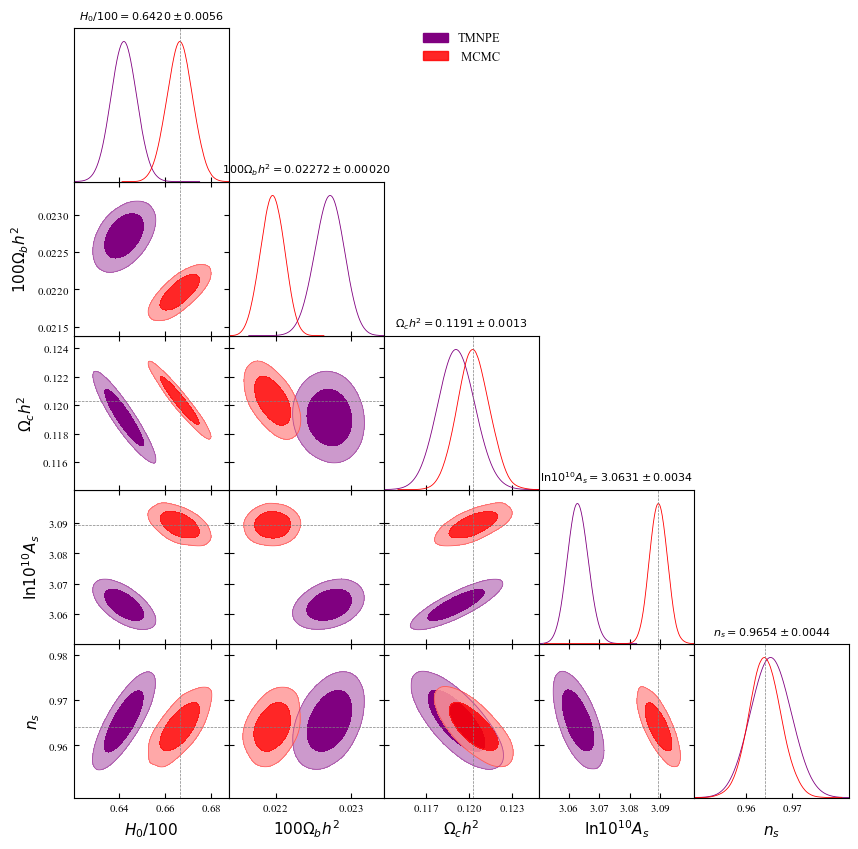

In [23]:
from getdist import plots
from getdist import MCSamples

%matplotlib inline

param_names = ["param1", "param2", 'param3', 'param4', 'param5']
param_labels = [r"H_0 / 100", r"100 \Omega_b h^2", r'\Omega_c h^2', r'\ln 10^{10} A_s', r'n_s']

tmnpe_samples = MCSamples(samples=posterior_samples.numpy(), names=param_names, labels=param_labels)
mcmc_samples = MCSamples(samples=data_reshape, names=param_names, labels=param_labels)

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([ tmnpe_samples, mcmc_samples], filled=True, 
                contour_colors = ['purple', 'red', 'red'],
                legend_labels=['TMNPE', ' MCMC', 'NPE'], 
                markers ={'param1':0.6663, 'param2': 2.1963, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'}, 
                title_limit = 1
                
                );

In [24]:
def find_all(getdist_samples):
    mcmc_samples = MCSamples(samples=data_reshape, names=param_names, labels=param_labels)
    p = getdist_samples.getParams()
    p2 = mcmc_samples.getParams()

    params_sbi = [p.param1, p.param2,p.param3,p.param4,p.param5]
    params_mcmc = [p2.param1, p2.param2,p2.param3,p2.param4,p2.param5]

    mean_sbi = []
    err_sbi = []
    limits_sbi = []

    mean_mcmc = []
    err_mcmc = []
    limits_mcmc = []

    for i in range(5):
        mean_sbi_i = getdist_samples.mean(params_sbi[i])
        err_sbi_i = getdist_samples.std(params_sbi[i])
        limits_sbi_i = getdist_samples.twoTailLimits(params_sbi[i],0.95)
        mean_sbi.append(mean_sbi_i)
        err_sbi.append(err_sbi_i)
        limits_sbi.append(limits_sbi_i)

        mean_mcmc_i = mcmc_samples.mean(params_mcmc[i])
        err_mcmc_i = mcmc_samples.std(params_mcmc[i])
        limits_mcmc_i = mcmc_samples.twoTailLimits(params_mcmc[i],0.95)
        mean_mcmc.append(mean_mcmc_i)
        err_mcmc.append(err_mcmc_i)
        limits_mcmc.append(limits_mcmc_i)

    mean_sbi = np.array(mean_sbi)
    err_sbi = np.array(err_sbi)
    limits_sbi = np.array(limits_sbi)
    mean_mcmc = np.array(mean_mcmc)
    err_mcmc = np.array(err_mcmc)
    limits_mcmc = np.array(limits_mcmc)

    return mean_sbi, err_sbi, limits_sbi, mean_mcmc, err_mcmc, limits_mcmc

mean_sbi, err_sbi, limits_sbi, mean_mcmc, err_mcmc, limits_mcmc = find_all(tmnpe_samples)

print("shift: MCMC - SAMPLES:")
for i in range(5):
    print(mean_mcmc[i]-mean_sbi[i])

Removed no burn in
shift: MCMC - SAMPLES:
0.024335509439644798
-0.0007564942524819346
0.0011782037613027596
0.026258990016130745
-0.0013085941387914746


In [29]:
posterior_samples_shift = []
posterior_samples_np = np.array(posterior_samples)
for i in tqdm(range(len(posterior_samples))):
    samples_shifted = [posterior_samples_np[i][0]+0.024, 
                       (posterior_samples_np[i][1]-0.00075)*100,
                       posterior_samples_np[i][2]+0.00117,
                       posterior_samples_np[i][3]+0.02625,
                       posterior_samples_np[i][4]-0.0013]
    posterior_samples_shift.append(samples_shifted)


  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|██████████| 1000000/1000000 [00:29<00:00, 34073.13it/s]


Removed no burn in
Removed no burn in


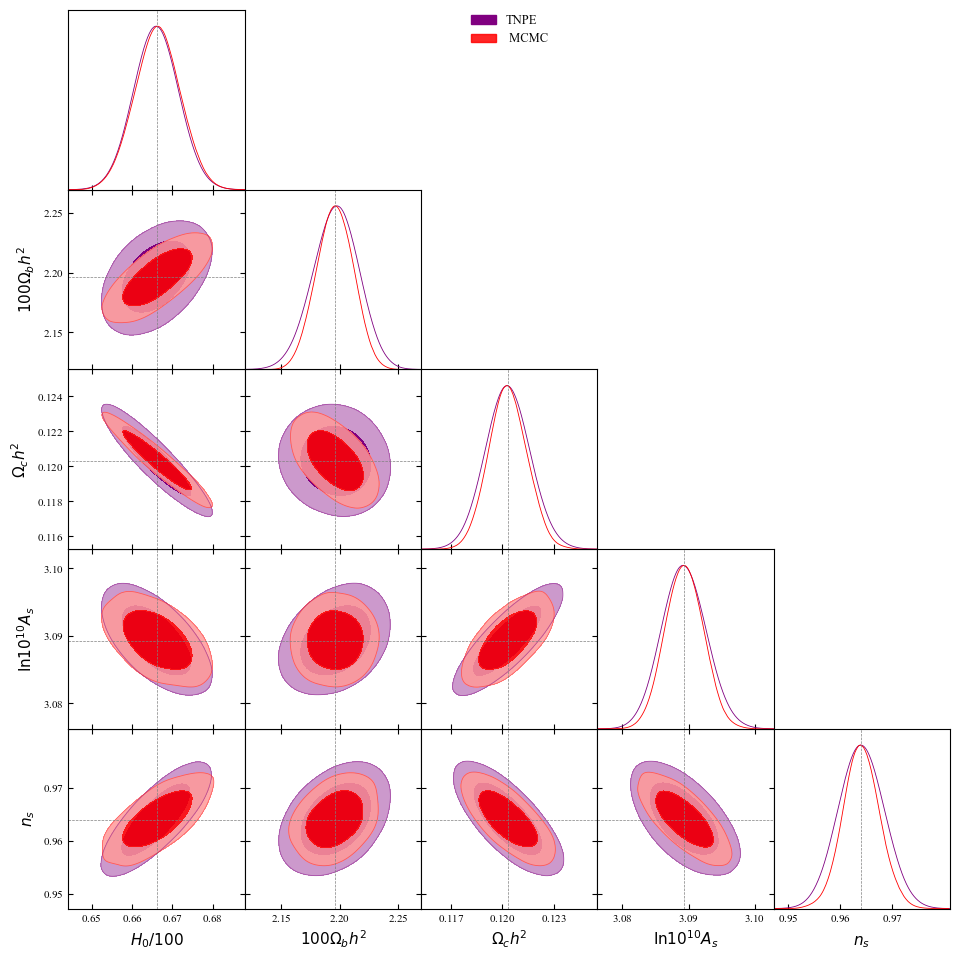

In [31]:
param_names = ["param1", "param2", 'param3', 'param4', 'param5']
param_labels = [r"H_0 / 100", r"100 \Omega_b h^2", r'\Omega_c h^2', r'\ln 10^{10} A_s', r'n_s']

tmnpe_samples = MCSamples(samples=np.array(posterior_samples_shift), names=param_names, labels=param_labels)
mcmc_samples = MCSamples(samples=data_reshape, names=param_names, labels=param_labels)

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([ tmnpe_samples, mcmc_samples], filled=True, 
                contour_colors = ['purple', 'red', 'red'],
                legend_labels=['TNPE', ' MCMC', 'NPE'], 
                markers ={'param1':0.6663, 'param2': 2.1963, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'}
                
                );

plt.savefig('tnpe_vs_mcmc.pdf')

In [32]:
np.save('/Users/aisulu/Desktop/report_code/final_results/tnpe_final_samples_scaled.npy', posterior_samples_shift)

In [23]:
with open ('/Users/aisulu/Desktop/report_code/sbi_samples/samples_npe_moped_10000_1000000.pkl', 'rb') as file:
    sbi_npe_final = pickle.load(file)

sbi_npe_final = np.array(sbi_npe_final)

npe_moped_sample = []
for i in range(len(sbi_npe_final)):
    h = sbi_npe_final[i][0]+0.01-0.001
    omb = (sbi_npe_final[i][1]*100-0.06+0.0028)/100
    omc = sbi_npe_final[i][2]-0.005+0.00027
    As = sbi_npe_final[i][3]+0.03
    ns = sbi_npe_final[i][4]+0.012-0.0007-0.0015
    npe_moped_sample.append([h, omb, omc, As, ns])
npe_moped_sample = np.array(npe_moped_sample)

Removed no burn in
Removed no burn in


Removed no burn in


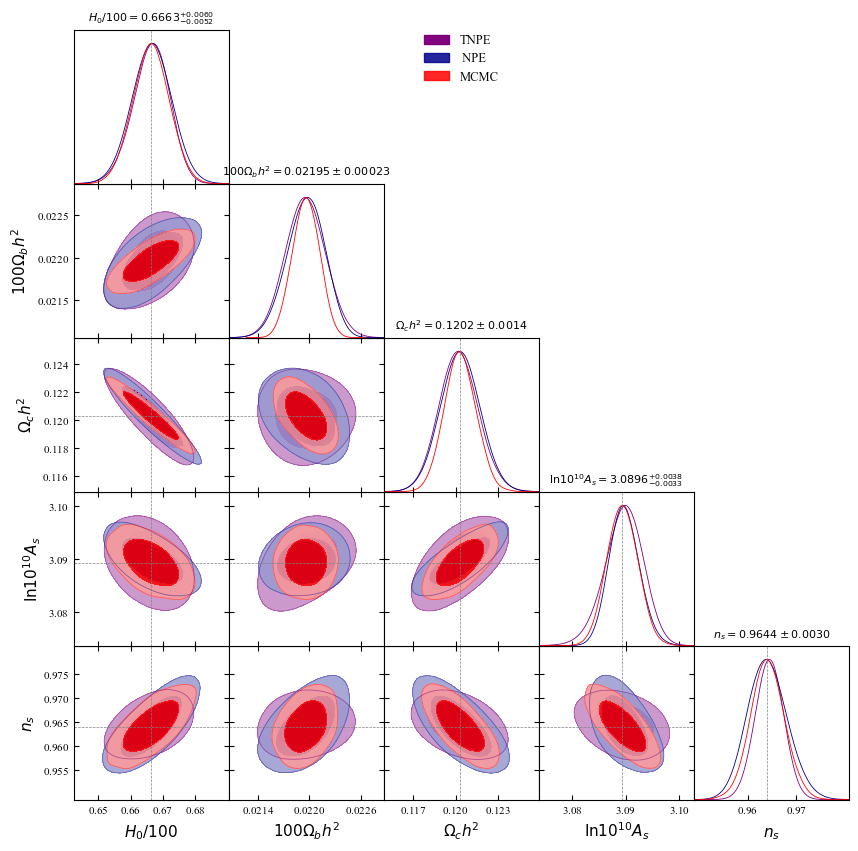

In [24]:
param_names = ["param1", "param2", 'param3', 'param4', 'param5']
param_labels = [r"H_0 / 100", r"100 \Omega_b h^2", r'\Omega_c h^2', r'\ln 10^{10} A_s', r'n_s']

tmnpe_samples = MCSamples(samples=np.array(posterior_samples_shift), names=param_names, labels=param_labels)
npe_samples =MCSamples(samples=npe_moped_sample, names=param_names, labels=param_labels)
mcmc_samples = MCSamples(samples=data_reshape, names=param_names, labels=param_labels)

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([ tmnpe_samples, npe_samples, mcmc_samples], filled=True, 
                contour_colors = ['purple', 'darkblue', 'red'],
                legend_labels=['TNPE', ' NPE', 'MCMC'], 
                markers ={'param1':0.6663, 'param2': 2.1963, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'}, 
                title_limit = 1
                
                );

In [25]:
with open('/Users/aisulu/Desktop/report_code/final_results/tnpe_posterior.pkl', 'wb') as file:
    pickle.dump(posterior, file)

np.save('/Users/aisulu/Desktop/report_code/final_results/tnpe_samples.npy',npe_moped_sample )
np.save('/Users/aisulu/Desktop/report_code/final_results/mcmc_samples.npy',data_reshape )
np.save('/Users/aisulu/Desktop/report_code/final_results/npe_samples.npy',np.array(posterior_samples_shift) )


In [ ]:
def find_all(getdist_samples):
    mcmc_samples = MCSamples(samples=data_reshape, names=param_names, labels=param_labels)
    p = getdist_samples.getParams()
    p2 = mcmc_samples.getParams()

    params_sbi = [p.param1, p.param2,p.param3,p.param4,p.param5]
    params_mcmc = [p2.param1, p2.param2,p2.param3,p2.param4,p2.param5]

    mean_sbi = []
    err_sbi = []
    limits_sbi = []

    mean_mcmc = []
    err_mcmc = []
    limits_mcmc = []

    for i in range(5):
        mean_sbi_i = getdist_samples.mean(params_sbi[i])
        err_sbi_i = getdist_samples.std(params_sbi[i])
        limits_sbi_i = getdist_samples.twoTailLimits(params_sbi[i],0.95)
        mean_sbi.append(mean_sbi_i)
        err_sbi.append(err_sbi_i)
        limits_sbi.append(limits_sbi_i)

        mean_mcmc_i = mcmc_samples.mean(params_mcmc[i])
        err_mcmc_i = mcmc_samples.std(params_mcmc[i])
        limits_mcmc_i = mcmc_samples.twoTailLimits(params_mcmc[i],0.95)
        mean_mcmc.append(mean_mcmc_i)
        err_mcmc.append(err_mcmc_i)
        limits_mcmc.append(limits_mcmc_i)

    mean_sbi = np.array(mean_sbi)
    err_sbi = np.array(err_sbi)
    limits_sbi = np.array(limits_sbi)
    mean_mcmc = np.array(mean_mcmc)
    err_mcmc = np.array(err_mcmc)
    limits_mcmc = np.array(limits_mcmc)

    return mean_sbi, err_sbi, limits_sbi, mean_mcmc, err_mcmc, limits_mcmc

mean_sbi, err_sbi, limits_sbi, mean_mcmc, err_mcmc, limits_mcmc = find_all(tmnpe_samples)

print("shift: MCMC - SAMPLES:")
for i in range(5):
    print(mean_mcmc[i]-mean_sbi[i])

Removed no burn in
shift: MCMC - SAMPLES:
-0.011336464786293576
-0.00045122687872263534
0.0007119016251646709
0.014932356986192996
-0.0020497647453450174


In [27]:
snpe_samples_file = np.load('/Users/aisulu/Desktop/report_code/final_results/snpe_samples.npy')
snpe_samples = MCSamples(samples=snpe_samples_file, names=param_names, labels=param_labels)
mean_sbi, err_sbi, limits_sbi, mean_mcmc, err_mcmc, limits_mcmc = find_all(snpe_samples)

print("shift: MCMC - SAMPLES:")
for i in range(5):
    print(mean_mcmc[i]-mean_sbi[i])


Removed no burn in
Removed no burn in


shift: MCMC - SAMPLES:
-0.011336464786293576
-0.00045122687872263534
0.0007119016251646709
0.014932356986192996
-0.0020497647453450174


In [28]:
snpe_shift = []
for i in tqdm(range(len(snpe_samples_file))):
    samples_shifted = [snpe_samples_file[i][0]-0.011, 
                       snpe_samples_file[i][1]-0.00045,
                       snpe_samples_file[i][2]+0.0007,
                       snpe_samples_file[i][3]+0.0149,
                       snpe_samples_file[i][4]-0.002]
    snpe_shift.append(samples_shifted)

100%|██████████| 1000000/1000000 [01:14<00:00, 13425.27it/s]


Removed no burn in
Removed no burn in


Removed no burn in
Removed no burn in


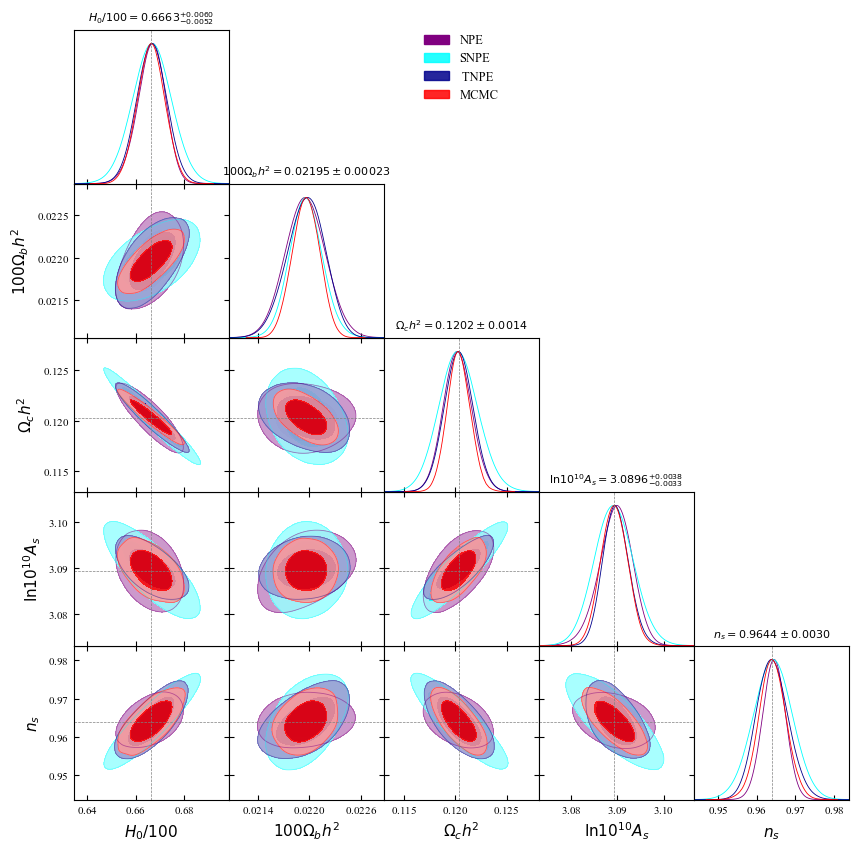

In [31]:
tmnpe_samples = MCSamples(samples=np.array(posterior_samples_shift), names=param_names, labels=param_labels)
npe_samples =MCSamples(samples=npe_moped_sample, names=param_names, labels=param_labels)
mcmc_samples = MCSamples(samples=data_reshape, names=param_names, labels=param_labels)
snpe_samples = MCSamples(samples=np.array(snpe_shift), names=param_names, labels=param_labels)

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([ tmnpe_samples,snpe_samples, npe_samples, mcmc_samples], filled=True, 
                contour_colors = ['purple','cyan', 'darkblue', 'red'],
                legend_labels=['NPE', 'SNPE', ' TNPE', 'MCMC'], 
                markers ={'param1':0.6663, 'param2': 2.1963, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'}, 
                title_limit = 1
                
                );

In [32]:
np.save ('/Users/aisulu/Desktop/report_code/final_results/snpe_samples.npy', snpe_shift)

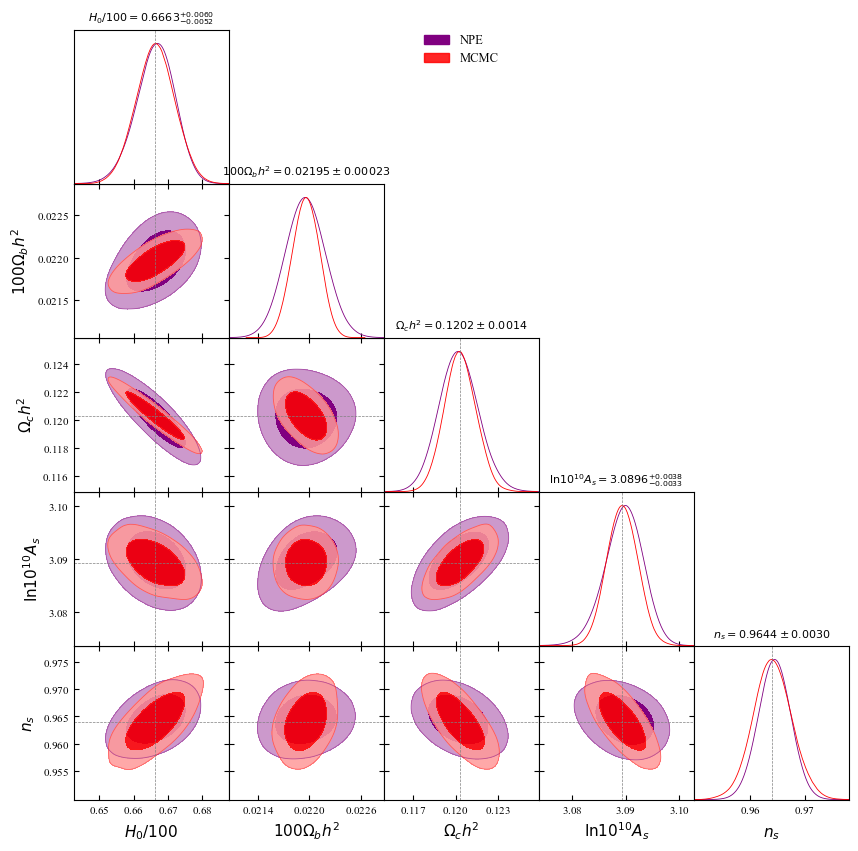

In [34]:
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([ tmnpe_samples, mcmc_samples], filled=True, 
                contour_colors = ['purple', 'red'],
                legend_labels=['NPE', 'MCMC'], 
                markers ={'param1':0.6663, 'param2': 2.1963, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'}, 
                title_limit = 1
                
                );

In [47]:
from sbi.analysis.plot import sbc_rank_plot
from sbi.analysis import check_sbc, run_sbc

num_posterior_samples = 1_000
ranks, dap_samples = run_sbc(torch.tensor(params[:300]), torch.tensor(cls[:300]),
    posterior,
    num_posterior_samples=num_posterior_samples,
    reduce_fns=posterior.log_prob,
)
check_stats = check_sbc(ranks, torch.tensor(params[:300]), dap_samples, 1_000)
print(check_stats)

/Users/aisulu/anaconda3/envs/myenv/lib/python3.8/site-packages/sbi/analysis/sbc.py:56: UserWarning: Number of SBC samples should be on the order of 100s to give realiable
            results. We recommend using 300.
  warnings.warn(


Running 300 sbc samples.:   0%|          | 0/300 [00:00<?, ?it/s]

{'ks_pvals': tensor([0.7363]), 'c2st_ranks': tensor([0.5133]), 'c2st_dap': tensor([0.4750, 0.4833, 0.5133, 0.4617, 0.5567])}


In [48]:
from torch import tensor, as_tensor, Tensor, eye, zeros, ones, float32
def coverage(
    posterior,
    theta,
    x,
    num_x: int = 100,
    alpha=torch.linspace(0, 1, 50),
    num_monte_carlo: int = 1_000,
):
    posterior = deepcopy(posterior)
    gt_is_covered = zeros(alpha.shape)
    x = x
    theta = theta
    x = x[:num_x]
    theta = theta[:num_x]
    with tqdm(total=len(theta)) as pbar:
        for params, summstats in tqdm(zip(theta, x)):
            xo = summstats
            posterior.set_default_x(xo)
            lprobs = posterior.log_prob(
                posterior.sample((num_monte_carlo,), show_progress_bars=False)
            )
            gt_log_prob = posterior.log_prob(
                as_tensor(np.asarray([params]), dtype=float32)
            )
            rank_of_gt = compute_rank(gt_log_prob, lprobs)
            norm_rank = rank_of_gt / lprobs.shape[0]
            covered_in_alpha_quantile = norm_rank > alpha
            gt_is_covered += covered_in_alpha_quantile.float()
            pbar.update(1)
    gt_is_covered /= num_x
    return alpha, torch.flip(gt_is_covered, dims=[0])

def compute_rank(val: Tensor, vec: Tensor):
    c = torch.cat([vec, val])
    s = torch.argsort(c)
    ind = torch.where(s == len(c) - 1)
    return ind[0]  # .where returns a tuple

In [49]:
th_coverage = params[:100]
x_coverage = cls[:100]

alpha, cov = coverage(posterior,th_coverage, x_coverage)

100it [00:02, 43.19it/s][00:02<00:00, 45.14it/s]
100%|██████████| 100/100 [00:02<00:00, 43.12it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

100it [00:02, 43.90it/s][00:02<00:00, 49.74it/s]
100%|██████████| 100/100 [00:02<00:00, 43.85it/s]


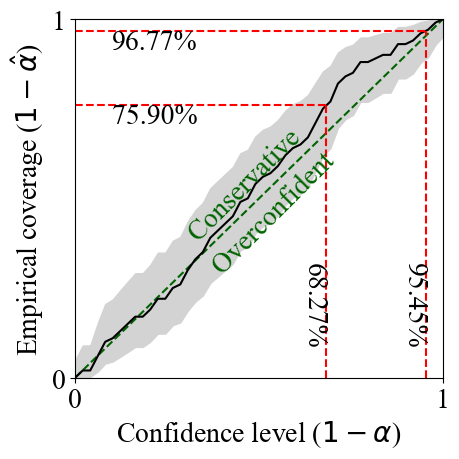

In [89]:
from scipy.stats import beta
alpha, cov = coverage(posterior,th_coverage, x_coverage)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
def jeffreys_interval(successes, trials, confidence_level=0.95):
    # Calculate the parameters for the Jeffrey's prior
    alpha_prior = 0.5 + successes
    beta_prior = 0.5 + trials - successes
    
    # Compute the lower and upper bounds of the confidence interval
    lower_bound = beta.ppf((1 - confidence_level) / 2, alpha_prior, beta_prior)
    upper_bound = beta.ppf(1 - (1 - confidence_level) / 2, alpha_prior, beta_prior)
    
    return lower_bound, upper_bound

def plot_coverage(alpha, gt_is_covered):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    lower_bound, upper_bound = jeffreys_interval(gt_is_covered*len(gt_is_covered), len(gt_is_covered))
    ax.fill_between(alpha, lower_bound, upper_bound, color = 'lightgrey')
    ax.plot([0, 1.0], [0, 1.0], '--', c="darkgreen")
    ax.plot(alpha, gt_is_covered, c = 'black')
    for interval in [0.6827, 0.9545]:
        empirical_i = np.interp(interval, alpha, gt_is_covered)
        ax.plot([interval, interval], [0,empirical_i ], '--', c='red')
        ax.text(interval-0.07,0.1, "%.2f" % (interval*100) + "%" , rotation = -90)
        ax.plot([0,interval ], [empirical_i, empirical_i], '--', c='red')
        if empirical_i<1:
            ax.text(0.1,empirical_i-0.05, "%.2f" % (empirical_i*100) + "%" )
    ax.text(1/ 2 + 0.04, 1/ 2 - 0.04, "Overconfident", ha="center", va="center", rotation=45,color="darkgreen")
    ax.text(1/ 2 - 0.04, 1/ 2 + 0.04, "Conservative", ha="center", va="center", rotation=45,color="darkgreen")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel(r"Confidence level ($1-\alpha$)")
    ax.set_ylabel(r"Empirical coverage ($1-\hat{\alpha}$)")
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    plt.tight_layout()

plot_coverage(alpha, cov)
#plt.savefig('npe_coverage_test.pdf')

In [ ]:
def plot_coverage(alpha, gt_is_covered):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    lower_bound, upper_bound = jeffreys_interval(gt_is_covered*len(gt_is_covered), len(gt_is_covered))
    zscore
    ax.fill_between(alpha, lower_bound, upper_bound, color = 'lightgrey')
    ax.plot([0, 1.0], [0, 1.0], '--', c="darkgreen")
    ax.plot(alpha, gt_is_covered, c = 'black')
    for interval in [0.6827, 0.9545]:
        empirical_i = np.interp(interval, alpha, gt_is_covered)
        ax.plot([interval, interval], [0,empirical_i ], '--', c='red')
        ax.text(interval-0.07,0.1, "%.2f" % (interval*100) + "%" , rotation = -90)
        ax.plot([0,interval ], [empirical_i, empirical_i], '--', c='red')
        if empirical_i<1:
            ax.text(0.1,empirical_i-0.05, "%.2f" % (empirical_i*100) + "%" )
    ax.text(1/ 2 + 0.04, 1/ 2 - 0.04, "Overconfident", ha="center", va="center", rotation=45,color="darkgreen")
    ax.text(1/ 2 - 0.04, 1/ 2 + 0.04, "Conservative", ha="center", va="center", rotation=45,color="darkgreen")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel(r"Confidence level ($1-\alpha$)")
    ax.set_ylabel(r"Empirical coverage ($1-\hat{\alpha}$)")
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    plt.tight_layout()

In [52]:
with open('/Users/aisulu/Desktop/report_code/final_results/tnpe_posterior.pkl', 'rb') as file:
    posterior_npe = pickle.load(file)

100it [00:02, 45.48it/s][00:02<00:00, 47.86it/s]
100%|██████████| 100/100 [00:02<00:00, 45.43it/s]


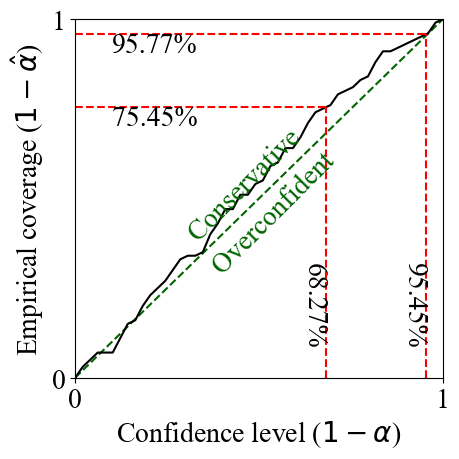

In [55]:
alpha2, cov2 = coverage(posterior_npe,th_coverage, x_coverage)
plot_coverage(alpha2, cov2)
plt.savefig('tnpe_coverage_test.pdf')

In [56]:
quant = 0.0
lower_quantile = torch.quantile(posterior_samples, torch.tensor(quant), dim=0)
upper_quantile = torch.quantile(posterior_samples, torch.tensor(1 - quant), dim=0)
print(lower_quantile)
print(upper_quantile)

tensor([0.6158, 0.0218, 0.1128, 3.0480, 0.9441])
tensor([0.6706, 0.0236, 0.1257, 3.0796, 0.9847])


In [57]:
print(pl)

[0.676, 0.0224, 0.12, 3.0753, 0.965]


In [58]:
print(limits_sbi)

[[0.63101685 0.6530096 ]
 [0.0223241  0.0230893 ]
 [0.11659426 0.12174249]
 [3.056565   3.069824  ]
 [0.9567972  0.9740606 ]]


In [74]:
low0 = torch.tensor([param_min[0], param_min[1]*100])
high0 = torch.tensor([param_max[0], param_max[1]*100])

low1 = torch.tensor([0.6340, 0.0213*100])
high1 = torch.tensor([0.7282, 0.0234*100])

low2 = torch.tensor([0.65,0.0218*100])
high2 = torch.tensor([0.69, 0.0230*100])

samples00 = np.random.uniform(low = low0[0], high = high0[0], size = 5000)
samples01 = np.random.uniform(low = low0[1], high = high0[1], size = 5000)

samples10 = np.random.uniform(low = low1[0], high = high1[0], size = 5000)
samples11 = np.random.uniform(low = low1[1], high = high1[1], size = 5000)

samples20 = np.random.uniform(low = low2[0], high = high2[0], size = 10000)
samples21 = np.random.uniform(low = low2[1], high = high2[1], size = 10000)

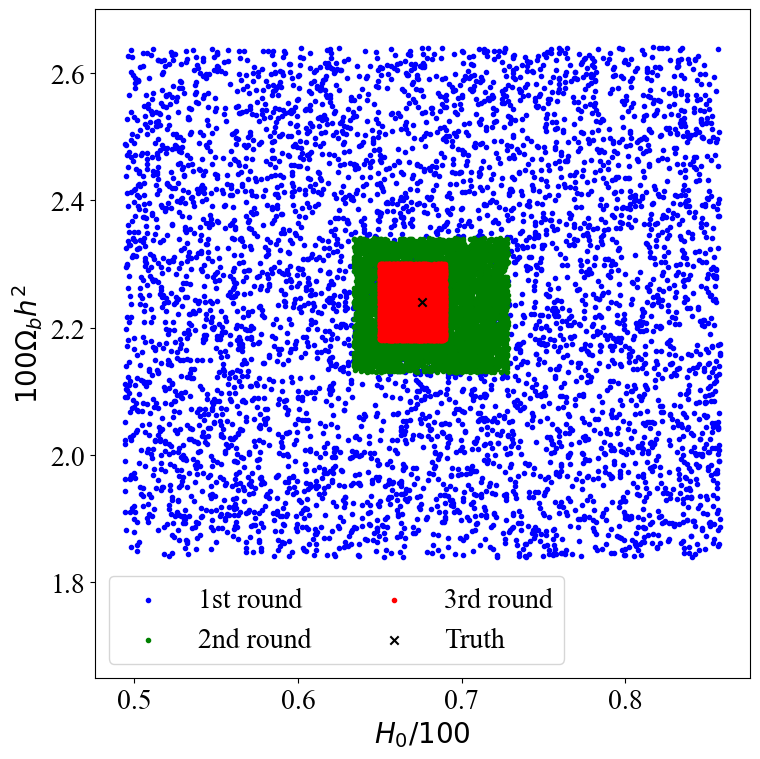

In [85]:
plt.figure(figsize=(8, 8))

plt.scatter(samples00, samples01, marker = '.',color = 'blue', label = '1st round')
plt.scatter(samples10, samples11, marker = '.', color = 'green', label = '2nd round')
plt.scatter(samples20, samples21, marker = '.', color = 'red', label = '3rd round')
plt.scatter(pl[0], pl[1]*100, marker = 'x', color = 'black', label = 'Truth')
plt.xlabel(r'$H_0/100$')
plt.ylabel(r'$100 \Omega_b h^2$')
plt.ylim([1.65, 2.7])
plt.legend(ncol = 2)

plt.tight_layout()

plt.savefig('truncation_result.pdf')

In [91]:
print(param_max)
print(param_min)

[0.8580078504801263, 0.026400106044642983, 0.16130777060165918, 3.16211000894321, 1.0688907350750636]
[0.4939921495198738, 0.018399893955357016, 0.0786922293983408, 2.98848999105679, 0.8611092649249363]
